# Development zone for drillhole class in Cython

# TODO: Add into a ```pyx``` file, ```setup.py ``` and ```__init__.py```

```
!-----------------------------------------------------------------------
!   PyGSLIB Desurvey, Module to calculate drillhole coordinates at 
!   interval tables and other drillhole relate process.  
! 
!   Copyright (C) 2015 Adrian Martinez Vargas 
!
!   This program is free software; you can redistribute it and/or modify
!   it under the terms of the GNU General Public License as published by
!   the Free Software Foundation; either version 3 of the License, or
!   any later version.
!    
!   This program is distributed in the hope that it will be useful,
!   but WITHOUT ANY WARRANTY; without even the implied warranty of
!   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
!   GNU General Public License for more details.
!   
!   You should have received a copy of the GNU General Public License
!   along with this program.  If not, see <http://www.gnu.org/licenses/>
!-----------------------------------------------------------------------
```

In [1]:
# load some modules
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
%load_ext Cython
%matplotlib inline  

In [2]:
a= {1:40, 2: 70}
print a.keys()

[1, 2]


In [3]:
%%cython
cimport numpy as np
import numpy as np
from libc.math cimport sin
from libc.math cimport cos
from libc.math cimport acos
from libc.math cimport asin
from libc.math cimport tan
from libc.math cimport atan2
import pandas as pd
import warnings

#-------------------------------------------------------------------
#  General functions
#-------------------------------------------------------------------
cpdef ang2cart( float azm,
                float dip):
    """
    get azimuth and dip (downward positive) and convert it to x,y,z
    angles are in degrees
    x,y,z are vectors with origin 0,0,0
    for example: [0,x]
    """

    # output 
    cdef float x
    cdef float y
    cdef float z

    # internal
    cdef float razm
    cdef float rdip
    cdef float DEG2RAD

    DEG2RAD=3.141592654/180.0

    # convert degree to rad and correct sign of dip
    razm = azm * DEG2RAD
    rdip = -dip * DEG2RAD

    # do the conversion
    x = sin(razm) * cos(rdip)
    y = cos(razm) * cos(rdip)
    z = sin(rdip)

    return x,y,z



cpdef cart2ang( float x,
                float y,
                float z):
    """
    convert x,y,z to azimuth, dip (downward positive) 
    angles are in degrees
    x,y,z are assumed vectors with origin 0,0,0
    for example: [0,x]
    """

    # out 
    cdef float azm
    cdef float dip


    # internal
    cdef float razm
    cdef float rdip
    cdef float RAD2DEG
    cdef float pi

    RAD2DEG=180.0/3.141592654
    pi = 3.141592654

    if x!=0. and y!= 0.: 
        azm= atan2(x,y)
        if azm<0:  
            azm= azm + pi*2
        azm = azm * RAD2DEG
    else: 
        azm = 0


    dip = -asin(z) * RAD2DEG

    return azm, dip


cpdef interp_ang1D( float azm1,
                    float dip1,
                    float azm2,
                    float dip2,
                    float len12,
                    float d1):
    """
    Interpolate the azimuth and dip angle over a line:
    given two points (p1, p2) over a line (1D problem);
    this subroutine calculate the average azimuth and dip of a point 
    between p1 and p2, located at a distance d1 from p1 one and a 
    distance len12-d1 from p2

    to do this we convert the (azimuth,dip) to (x,y,z), we 
    interpolate x,y,z and then we convert back to (azimuth,dip)
    """
    # output
    cdef float azm
    cdef float dip

    # internal
    cdef float x1
    cdef float y1
    cdef float z1
    cdef float x2
    cdef float y2
    cdef float z2
    cdef float x
    cdef float y
    cdef float z


    # convert angles to coordinates
    x1,y1,z1 = ang2cart(azm1,dip1)
    x2,y2,z2 = ang2cart(azm2,dip2)

    # interpolate x,y,z
    x = x2*d1/len12 + x1*(len12-d1)/len12 
    y = y2*d1/len12 + y1*(len12-d1)/len12
    z = z2*d1/len12 + z1*(len12-d1)/len12

    # get back the results as angles
    azm,dip = cart2ang(x,y,z)

    return azm, dip

cpdef dsmincurb( float len12,
                 float az1,
                 float dip1,
                 float az2,
                 float dip2):
    # using formulas in http://www.cgg.com/data//1/rec_docs/2269_MinimumCurvatureWellPaths.pdf
    # here we calculate the deltas only... 

    # output
    cdef float dz
    cdef float dn
    cdef float de 


    # internal 
    cdef float i1
    cdef float a1
    cdef float i2
    cdef float a2
    cdef float DEG2RAD
    cdef float rf
    cdef float dl

    DEG2RAD=3.141592654/180.0

    i1 = (90 - dip1) * DEG2RAD
    a1 = az1 * DEG2RAD

    i2 = (90 - dip2) * DEG2RAD
    a2 = az2 * DEG2RAD

    # calculate the dog-leg (dl) and the Ratio Factor (rf)
    dl = acos(cos(i2-i1)-sin(i1)*sin(i2)*(1-cos(a2-a1))) 

    if dl!=0.: 
        rf = 2*tan(dl/2)/dl  # minimum curvature
    else:
        rf=1                 # balanced tangential



    dz = 0.5*len12*(cos(i1)+cos(i2))*rf
    dn = 0.5*len12*(sin(i1)*cos(a1)+sin(i2)*cos(a2))*rf
    de = 0.5*len12*(sin(i1)*sin(a1)+sin(i2)*sin(a2))*rf

    return dz,dn,de

cpdef desurv1dh(int indbs,
               int indes,
               np.ndarray[double, ndim=1] ats,
               np.ndarray[double, ndim=1] azs,
               np.ndarray[double, ndim=1] dips,
               float xc,
               float yc,
               float zc,
               float lpt):

    """
    desrurvey point in a drillhole trace and located at a depth lpt
    """


    # output (anges at begin, mid and end interval)
    cdef float azt
    cdef float dipt
    cdef float xt
    cdef float yt
    cdef float zt

    # internal
    cdef int i
    cdef int j
    cdef float a,
    cdef float b
    cdef float azm1
    cdef float dip1
    cdef float azm2
    cdef float dip2
    cdef float len12
    cdef float d1
    cdef float EPSLON=1.0e-4
    cdef float xa
    cdef float ya
    cdef float za
    cdef float xb
    cdef float yb
    cdef float zb
    cdef float dz
    cdef float dn
    cdef float de

    assert ats[indbs]<EPSLON, 'first survey > 0 at %d' % indbs

    for i in range (indbs,indes):
        # get the segment [a-b] to test interval
        a=ats[i]
        b=ats[i+1]
        azm1 = azs[i]
        dip1 = dips[i]
        azm2 = azs[i+1]
        dip2 = dips[i+1]
        len12 = ats[i+1]-ats[i]
        # desurvey at survey table
        if ats[i]>=-EPSLON and ats[i]<=EPSLON: #zero interval?
            xa = xc
            ya = yc
            za = zc
            # desurvey interval at zurvey... table

            dz,dn,de = dsmincurb(len12,azm1,dip1,azm2,dip2)

            xb = xa+de
            yb = ya+dn
            zb = za-dz
        else:
            xa = xb
            ya = yb
            za = zb
            # desurvey interval at zurvey... table
            dz,dn,de = dsmincurb(len12,azm1,dip1,azm2,dip2)
            xb = xa+de
            yb = ya+dn
            zb = za-dz


        # test if we are in the interval, interpolate angles
        if lpt>=a  and lpt<b:
            d1= lpt- a

            azt,dipt = interp_ang1D(azm1,dip1,azm2,dip2,len12,d1)

            # desurvey at interval table 
            dz,dn,de = dsmincurb(d1,azm1,dip1,azt,dipt)

            xt = xa+de
            yt = ya+dn
            zt = za-dz 

            return azt, dipt, xt, yt, zt
    
    a=ats[indes]
    azm1 = azs[indes]
    dip1 = dips[indes]
    azt = azm1
    dipt = dip1
    # the point is beyond the last survey? 
    if lpt>=a:
        d1= lpt- a
        # desurvey at interval table 
        dz,dn,de = dsmincurb(d1,azm1,dip1,azt,dipt)
        xt = xa+de
        yt = ya+dn
        zt = za-dz 
        
        warnings.warn('\n point beyond the last survey point at %s' % indes)
    else:
        warnings.warn('\n not interval found at survey, at %s' % indes)

    return   azt, dipt, xt, yt, zt

#-------------------------------------------------------------------
#  Drillhole class
#-------------------------------------------------------------------
cdef class Drillhole:
    """
    add doc string here
    """ 
    cdef readonly object collar
    cdef readonly object survey
    cdef readonly object table
    
    property table_mames:
        def __get__(self):
            return self.table.keys()
    
    def __init__(self, collar, survey):
        """
        add doc string here
        """
        #check the input is correct
        assert isinstance(collar, pd.DataFrame), "collar is not a pandas DataFrame" 
        assert isinstance(survey, pd.DataFrame), "survey is not a pandas DataFrame" 
        
        #check we have the rigth naming in collar columns 
        assert 'BHID' in collar.columns, "collar don't have BHID column"
        assert 'XCOLLAR' in collar.columns, "collar don't have XCOLLAR column"
        assert 'YCOLLAR' in collar.columns, "collar don't have YCOLLAR column"
        assert 'ZCOLLAR' in collar.columns, "collar don't have ZCOLLAR column"
        
        #check we have the rigth naming in survey columns 
        assert 'BHID' in survey.columns, "survey don't have BHID column"
        assert 'AT' in survey.columns, "survey don't have AT column"
        assert 'AZ' in survey.columns, "survey don't have AZ column"
        assert 'DIP' in survey.columns, "survey don't have DIP column"
        
        
        self.collar = collar
        self.survey = survey
        self.table = {}
        
           
    
    cpdef addtable(self,object table,str table_name,bint overwrite =False):
        """
        add doc string here
        """        
        #check the input is correct
        assert isinstance(table, pd.DataFrame), "table is not a pandas DataFrame"
        #assert isinstance(table_name, str), "table_name is not a string"
        
        #check we have the rigth naming in columns 
        assert 'BHID' in table.columns, "%s don't have BHID" %table_name
        assert 'FROM' in table.columns, "%s don't have FROM" %table_name
        assert 'TO' in table.columns, "%s don't have TO" %table_name
        
        
        if table_name not in self.table:
            self.table[table_name]=table
        else:
            if overwrite == True: 
                self.table[table_name]=table
            else:
                raise NameError('Table %s already exist, use overwrite = True to overwrite' % table_name)
            
        
    cpdef validate(self):
        
        #check collar
        # null values in collar
        if self.collar['BHID'].hasnans():
            raise NameError('Non defined BHID in collar table')
        if self.collar['XCOLLAR'].hasnans():
            raise NameError('Non defined XCOLLAR in collar table')
        if self.collar['YCOLLAR'].hasnans():
            raise NameError('Non defined YCOLLAR in collar table')
        if self.collar['ZCOLLAR'].hasnans():
            raise NameError('Non defined ZCOLLAR in collar table')
        if self.collar['XCOLLAR'].dtypes!='float64':
            raise NameError('XCOLLAR in collar table != float64')            
        if self.collar['YCOLLAR'].dtypes!='float64':
            raise NameError('YCOLLAR in collar table != float64')
        if self.collar['ZCOLLAR'].dtypes!='float64':
            raise NameError('ZCOLLAR in collar table != float64')

        #check SURVEY
        # null values in survey
        if self.survey['BHID'].hasnans():
            raise NameError('Non defined BHID in survey table')
        if self.survey['AT'].hasnans():
            raise NameError('Non defined AT in survey table')
        if self.survey['AZ'].hasnans():
            raise NameError('Non defined AZ in survey table')
        if self.survey['DIP'].hasnans():
            raise NameError('Non defined DIP in survey table')
        if self.survey['AT'].dtypes!='float64':
            raise NameError('AT in survey table != float64')            
        if self.survey['DIP'].dtypes!='float64':
            raise NameError('DIP in survey table != float64')
        if self.survey['AZ'].dtypes!='float64':
            raise NameError('AZ in survey table != float64')
        
        #check survey without values: at=0
        self.survey.sort(columns=['BHID','AT'], inplace=True)
        error = self.__checkAt0(self.survey['BHID'].values, self.survey['AT'].values)
        if error>-1:
            raise NameError('Firts inteval AT!=0 at survey table, positiom %d' %error) 
            
        return None
        # TODO: check table relationship
        
    cdef __checkAt0(self,np.ndarray BHID, np.ndarray[double, ndim=1] AT):
        # this is a hide function
        # the input data is assumed sorted
        cdef int n= AT.shape[0]
        cdef int i, start
    
        
        # first interval is zero
        if  AT[0]>0.00001:
            return 0
            
        # the first dhole intervals (where BHID[i-1]!=BHID[i]) are zero?
        for i in range(1,n):
            if BHID[i-1]!=BHID[i]:
                if  AT[i]>0.00001: 
                   return i
        
        return -1
            
        
    cpdef validate_table(self, table_name):    
        #check the input is correct
        assert isinstance(table_name, str), 'table_name is not a string'
        assert table_name in self.table, '%s not exist in this drillhole database' % table_name
        
        #check table
        # null values in table bhid
        if self.table[table_name]['BHID'].hasnans():
            raise NameError('Non defined BHID in %s' % table_name)
        # null values in From/To
        if self.table[table_name]['FROM'].hasnans():
            raise NameError('Non defined FROM in %s' % table_name)
        if self.table[table_name]['TO'].hasnans():
            raise NameError('Non defined TO in %s' % table_name)
        if self.table[table_name]['FROM'].dtypes!='float64':
            raise NameError('FROM in table %s != float64' % table_name)
        if self.table[table_name]['TO'].dtypes!='float64':
            raise NameError('TO in table %s != float64' % table_name)

        # TODO: check overlaps and table relationship

    
    cpdef txt2intID(self, str table_name):
        """
        add docstring ...
        
        convert text bhid to int bhid... This is handy for some fortran columns
        
        txt2intID(self, str table_name)
        
        """

        # the data is assumed sorted
        
        assert table_name in self.table, 'The table %s do not exist in the database' % table_name
        
        cdef int sloc
        cdef int i
        cdef int j
        cdef int nc = self.collar.shape[0]
        cdef int nt = self.table[table_name].shape[0]
        cdef np.ndarray[long, ndim=1] cBHID = np.zeros([nc], dtype=long)
        cdef np.ndarray[long, ndim=1] tBHID = np.zeros([nt], dtype=long)
        cdef np.ndarray[object, ndim=1] cTextID = np.empty([nc], dtype=object)
        cdef np.ndarray[object, ndim=1] tTextID = np.empty([nt], dtype=object)
        
        cTextID[:] = self.collar['BHID']
        tTextID[:] = self.table[table_name]['BHID']
        

        sloc = 0
        for i in range(nc):

            cBHID[i] = i+1

            # get first position
            for j in range(sloc, nt): 
                if cTextID[i] != tTextID[j]:
                    continue
                else:
                    sloc = j
                    break
            # operate in the first position 
            for j in range(sloc, nt): 
                if cTextID[i] == tTextID[j]:
                    tBHID[j]=cBHID[i] 
                else:
                    sloc = j
                    break  
        
        self.collar['BHIDint']= cBHID
        self.table[table_name]['BHIDint'] = tBHID

    cpdef desurvey(self, str table_name, bint endpoints=False):
        #check the input is correct
        assert table_name in self.table, "table %s not exist" % table_name
        
        
        cdef np.ndarray[object, ndim=1] idc = self.collar['BHID'].values
        cdef np.ndarray[double, ndim=1] xc = self.collar['XCOLLAR'].values
        cdef np.ndarray[double, ndim=1] yc = self.collar['YCOLLAR'].values
        cdef np.ndarray[double, ndim=1] zc = self.collar['ZCOLLAR'].values
        cdef np.ndarray[object, ndim=1] ids = self.survey['BHID'].values
        cdef np.ndarray[double, ndim=1] ats = self.survey['AT'].values
        cdef np.ndarray[double, ndim=1] azs = self.survey['AZ'].values
        cdef np.ndarray[double, ndim=1] dips = self.survey['DIP'].values
        cdef np.ndarray[object, ndim=1] idt =self.table[table_name]['BHID'].values
        cdef np.ndarray[double, ndim=1] fromt = self.table[table_name]['FROM'].values
        cdef np.ndarray[double, ndim=1] tot = self.table[table_name]['TO'].values 
                         
        # internal
        cdef int nc= idc.shape[0]
        cdef int ns= ids.shape[0]
        cdef int nt= idt.shape[0]
        cdef int jc
        cdef int js
        cdef int jt
        cdef int indbs
        cdef int indbt
        cdef int indes
        cdef int indet
        cdef int inds,
        cdef int indt
        cdef float mid
        
        # otput
        cdef np.ndarray[double, ndim=1] azmt = np.empty([nt], dtype=float)
        cdef np.ndarray[double, ndim=1] dipmt = np.empty([nt], dtype=float)
        cdef np.ndarray[double, ndim=1] xmt = np.empty([nt], dtype=float)
        cdef np.ndarray[double, ndim=1] ymt = np.empty([nt], dtype=float)
        cdef np.ndarray[double, ndim=1] zmt = np.empty([nt], dtype=float)
        
        #if endpoints==true:
        cdef float tmpaz, tmpdip
        cdef np.ndarray[double, ndim=1] xbt = np.empty([nt], dtype=float)
        cdef np.ndarray[double, ndim=1] ybt = np.empty([nt], dtype=float)
        cdef np.ndarray[double, ndim=1] zbt = np.empty([nt], dtype=float)
        cdef np.ndarray[double, ndim=1] xet = np.empty([nt], dtype=float)
        cdef np.ndarray[double, ndim=1] yet = np.empty([nt], dtype=float)
        cdef np.ndarray[double, ndim=1] zet = np.empty([nt], dtype=float)
              
        indbt = 0
        indet = 0 
        inds = 0
        indt = 0   
        for jc in range(nc):
            indbs = -1
            indes = -1
            # get first index of the collar jc in survey 
            for js in range(inds, ns):
                # find index beging and end for the actual collar
                if idc[jc]==ids[js]:
                    inds = js
                    indbs = js
                    break
            
            # get las index of the collar jc in survey 
            for js in range(inds, ns):
                # find index beging and end for the actual collar
                if idc[jc]!=ids[js]:
                    break
                else: 
                    inds = js
                    indes = js

            if indbs==-1 or indes==-1:
                # do not desurvey this drillhole
                warnings.warn('! collar without survey, table not desurveyed')
                continue
            
            # with the index indbs and indes we desurvey each collar
            for jt in range(indt, nt):
                # the table id is similar to collar? Then desurvey
                
                if idc[jc]==idt[jt]:
                    #desurvey this point
                    indt = jt # do not loop again before this index
                    
                    # desurvey mid interv                    
                    mid = fromt[jt] + (tot[jt]-fromt[jt])/2.
                    
                    azmt[jt],dipmt[jt],xmt[jt],ymt[jt],zmt[jt] = \
                    desurv1dh(indbs,indes,ats,azs,dips,xc[jc],yc[jc],zc[jc],mid)
                    
                    if endpoints==True:
                        tmpaz,tmpdip,xbt[jt],ybt[jt],zbt[jt] = \
                        desurv1dh(indbs,indes,ats,azs,dips,xc[jc],yc[jc],zc[jc],fromt[jt])
                        tmpaz,tmpdip,xet[jt],yet[jt],zet[jt] = \
                        desurv1dh(indbs,indes,ats,azs,dips,xc[jc],yc[jc],zc[jc],tot[jt])  
        
        self.table[table_name]['azm'] = azmt
        self.table[table_name]['dipm']= dipmt
        self.table[table_name]['xm']= xmt
        self.table[table_name]['ym']= ymt
        self.table[table_name]['zm']= zmt
        if endpoints==True:
            self.table[table_name]['xb']= xbt
            self.table[table_name]['yb']= ybt
            self.table[table_name]['zb']= zbt
            self.table[table_name]['xe']= xet
            self.table[table_name]['ye']= yet
            self.table[table_name]['ze']= zet

## Testing  this class

In [4]:
# a) import existing data
collar= pd.read_csv('dhole_data/collar.csv')
survey= pd.read_csv('dhole_data/survey.csv')
assay= pd.read_csv('dhole_data/assay.csv')
litho= pd.read_csv('dhole_data/litho.csv')

# survey is downhole negative, so we change the sign
survey.DIP=-survey.DIP

In [5]:
# creating the drillhole database
mydholedb=Drillhole(collar=collar,survey=survey)

In [6]:
mydholedb.addtable(assay, 'assay' ,overwrite = False)
mydholedb.addtable(litho, 'litho', overwrite = False)

In [7]:
print mydholedb.table_mames
print mydholedb.table['litho'].head(3)

['litho', 'assay']
    BHID   FROM      TO              LITHO_DESC
0  E-046   0.00   23.46                  Casing
1  E-046  23.46   86.25  Indifferenciated Tuffs
2  E-046  86.25  131.06  Porphyric Granodiorite


In [8]:
# Warining the data is linked to source
assay['BHID']= 'lala'
print assay.head(3)
print mydholedb.table['assay'].head(3)

   BHID      FROM        TO     AU
0  lala  70.71360  71.32320  0.026
1  lala  22.86000  23.59152  0.026
2  lala  35.29584  35.60064  0.686
   BHID      FROM        TO     AU
0  lala  70.71360  71.32320  0.026
1  lala  22.86000  23.59152  0.026
2  lala  35.29584  35.60064  0.686


In [9]:
mydholedb.validate()

In [10]:
mydholedb.validate_table('assay')
mydholedb.validate_table('litho')

In [11]:
mydholedb.txt2intID('assay')

In [12]:
mydholedb.collar

,BHID,XCOLLAR,YCOLLAR,ZCOLLAR,BHIDint
0,B-576,291492.30,5331488.57,-313.95,1
1,E-046,292322.80,5329541.71,326.43,2
2,E-133,292423.04,5329537.17,326.73,3
3,E-364,289971.66,5328599.92,326.73,4
4,P-338,291784.74,5329274.13,-103.94,5


In [13]:
# BHIDint = 0 means that the drillohole is not in the collar table (IDs are from one)
mydholedb.table['assay'].head()

,BHID,FROM,TO,AU,BHIDint
0,lala,70.71360,71.32320,0.026,0
1,lala,22.86000,23.59152,0.026,0
2,lala,35.29584,35.60064,0.686,0
3,lala,36.21024,36.33216,0.026,0
4,lala,39.86784,40.08120,0.026,0


In [14]:
mydholedb.txt2intID('litho')
mydholedb.table['litho'].head() # here the drillhole B-576 with BHIDint=1 is absent... 

,BHID,FROM,TO,LITHO_DESC,BHIDint
0,E-046,0.00,23.46,Casing,2
1,E-046,23.46,86.25,Indifferenciated Tuffs,2
2,E-046,86.25,131.06,Porphyric Granodiorite,2
3,E-046,131.06,157.88,Indifferenciated Tuffs,2
4,E-046,157.88,158.58,Porphyric Granodiorite,2


In [15]:
mydholedb.desurvey('litho')
mydholedb.table['litho'][mydholedb.table['litho']['BHID']=='E-046']

/home/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: UserWarning: 
 point beyond the last survey point at 7
  if __name__ == '__main__':


,BHID,FROM,TO,LITHO_DESC,BHIDint,azm,dipm,xm,ym,zm
0,E-046,0.00,23.46,Casing,2,342.309998,46.781525,292320.43750,5329549.0,317.660736
1,E-046,23.46,86.25,Indifferenciated Tuffs,2,342.309998,39.329010,292310.75000,5329579.0,288.640289
2,E-046,86.25,131.06,Porphyric Granodiorite,2,342.309998,34.139462,292297.65625,5329620.5,256.557007
3,E-046,131.06,157.88,Indifferenciated Tuffs,2,342.309998,31.376076,292288.50000,5329649.0,237.171402
4,E-046,157.88,158.58,Porphyric Granodiorite,2,342.309998,30.336117,292284.90625,5329660.5,230.102463
5,E-046,158.58,168.00,Indifferenciated Tuffs,2,342.309998,29.956472,292283.56250,5329664.5,227.555573
6,E-046,168.00,168.85,Porphyric Granodiorite,2,342.309998,29.572680,292282.21875,5329669.0,224.999756
7,E-046,168.85,185.01,Indifferenciated Tuffs,2,342.309998,28.940193,292279.96875,5329676.0,220.830414


#### Expected results (desurveyed with comercial softare)

BHID  |  X  |  Y  |  Z  |   AZM  |  DIP
--| 
E-046  |  292320.44  |  5329549.12  |  317.65  |  342.31  |  46.92
E-046  |  292310.76  |  5329579.47  |  288.63  |  342.31  |  39.40
E-046  |  292297.64  |  5329620.61  |  256.54  |  342.31  |  34.18
E-046  |  292288.50  |  5329649.27  |  237.15  |  342.31  |  31.44
E-046  |  292284.91  |  5329660.51  |  230.09  |  342.31  |  30.39
E-046  |  292283.58  |  5329664.67  |  227.54  |  342.31  |  30.00
E-046  |  292282.23  |  5329668.92  |  224.99  |  342.31  |  29.60
E-046  |  292279.97  |  5329675.99  |  220.83  |  342.31  |  28.95



In [16]:
mydholedb.collar[mydholedb.collar['BHID']=='E-046']

,BHID,XCOLLAR,YCOLLAR,ZCOLLAR,BHIDint
1,E-046,292322.8,5329541.71,326.43,2


In [17]:
mydholedb.survey[mydholedb.survey['BHID']=='E-046']

,BHID,AT,AZ,DIP
2,E-046,0.00,342.31,50.0
3,E-046,30.48,342.31,42.0
4,E-046,91.44,342.31,35.5
5,E-046,182.88,342.31,28.5


### testing some basic functions for desurvey

In [18]:
angles = pd.DataFrame (
    {'az'   : [0.,45,90,135,180,225,270,315,360,0,45,90,135,180,225,270,315],
     'dip': [90.,80,70,60,50,40,30,20,10,0,-10,-20,-30,-40,-50,-60,-70]})

angles['x']=0.
angles['y']=0.
angles['z']=0.

for i in range(len(angles)):
    x,y,z = ang2cart(azm=angles['az'][i],dip=angles['dip'][i])
    angles['x'][i]=x
    angles['y'][i]=y
    angles['z'][i]=z

angles['az_back']=0.
angles['dip_back']=0.

for i in range(len(angles)):
    a,d = cart2ang(x=angles['x'][i],
                                       y=angles['y'][i],
                                       z=angles['z'][i])
    angles['az_back'][i]=a
    angles['dip_back'][i]=d

    
angles

,az,dip,x,y,z,az_back,dip_back
0,0,90,-0.000000e+00,-4.371139e-08,-1.000000,0.000000,90.000000
1,45,80,1.227878e-01,1.227878e-01,-0.984808,45.000000,79.999992
2,90,70,3.420202e-01,-1.495018e-08,-0.939693,90.000000,70.000000
3,135,60,3.535534e-01,-3.535534e-01,-0.866025,135.000000,60.000008
4,180,50,-5.619428e-08,-6.427876e-01,-0.766044,180.000015,50.000000
5,225,40,-5.416752e-01,-5.416753e-01,-0.642788,225.000015,39.999996
6,270,30,-8.660254e-01,1.032725e-08,-0.500000,270.000000,30.000000
7,315,20,-6.644631e-01,6.644629e-01,-0.342020,315.000000,20.000000
8,360,10,1.721893e-07,9.848077e-01,-0.173648,0.000010,10.000000
9,0,0,0.000000e+00,1.000000e+00,-0.000000,0.000000,0.000000


### 1D interpolation of angles

### interpolate between two non vertical (dip=90) directions
**this works ** 

0 0.0 75.0
1 17.5149002075 70.0589370728
2 37.3490066528 66.0870056152
3 55.3591117859 62.657913208
4 69.1341018677 59.5869293213
5 78.9467468262 56.774055481
6 85.9129104614 54.1579589844
7 90.9761657715 51.6977920532
8 94.7679443359 49.3647270203
9 97.6901397705 47.1375312805
10 100.0 45.0


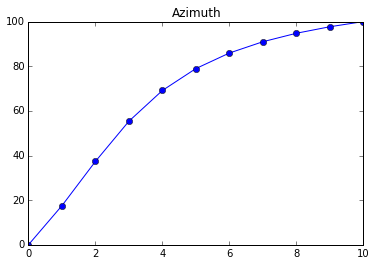

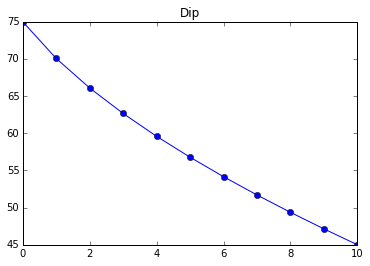

In [19]:
a=[]
d=[]
l=[]
for i in range(11):
    azm,dip = interp_ang1D(azm1=0,
                         dip1=75,
                         azm2=100,
                         dip2=45,
                         len12=10,
                         d1=i)
    print i, azm,dip
    
    a.append(azm)
    d.append(dip)
    l.append(i)

plt.plot(l,a, '-o')
plt.title('Azimuth')
plt.show()
plt.plot(l,d, '-o')
plt.title('Dip')
plt.show()

### Interpolate between vertical direction (dip=90) and non vertical

** this works but how to interpolate azimuth of a vertical drection? ** The result is a discontinuity and this is good for drillhole desurvey!

0 0.0 90.0
1 100.000038147 76.0986099243
2 100.000015259 70.2916488647
3 100.000007629 65.8016662598
4 100.000007629 61.9872055054
5 100.000007629 58.6002883911
6 100.0 55.5139503479
7 100.0 52.6528778076
8 100.0 49.968006134
9 100.0 47.4253158569
10 100.0 45.0


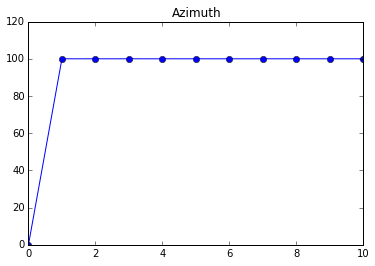

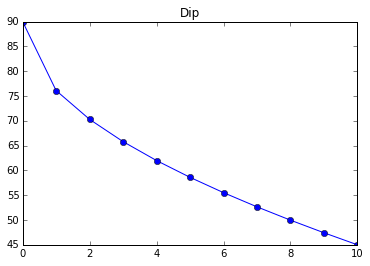

In [20]:
a=[]
d=[]
l=[]
for i in range(11):
    azm,dip = interp_ang1D(azm1=0,
                         dip1=90,
                         azm2=100,
                         dip2=45,
                         len12=10,
                         d1=i)
    print i, azm,dip
    
    a.append(azm)
    d.append(dip)
    l.append(i)

plt.plot(l,a, '-o')
plt.title('Azimuth')
plt.show()
plt.plot(l,d, '-o')
plt.title('Dip')
plt.show()

### Interpolate between two vertical directions (dip=90) 

The result is a discontinuity + inestable and not an issue for drillhole desurvey!

0 0.0 90.0
1 186.366500854 90.0
2 194.433258057 90.0
3 204.512802124 90.0
4 216.593658447 90.0
5 230.000015259 90.0
6 243.406356812 90.0
7 255.487213135 90.0
8 265.566772461 90.0
9 273.633514404 90.0
10 280.0 90.0


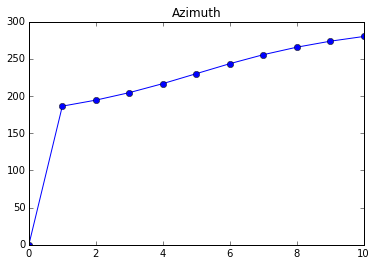

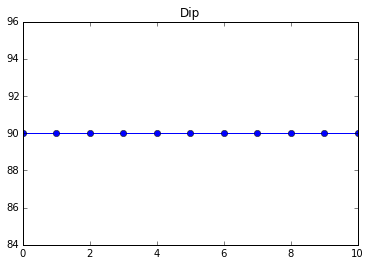

In [21]:
a=[]
d=[]
l=[]
for i in range(11):
    azm,dip = interp_ang1D(azm1=0,
                         dip1=90,
                         azm2=100,
                         dip2=90,
                         len12=10,
                         d1=i)
    print i, azm,dip
    
    a.append(azm)
    d.append(dip)
    l.append(i)

plt.plot(l,a, '-o')
plt.title('Azimuth')
plt.show()
plt.plot(l,d, '-o')
plt.title('Dip')
plt.show()

## Desurvey function (minimum curvature)
We use here minimum curvature with balanced tangential if the dog-leg (dl) is zero and makes the Ratio Factor (rf) undefined. It works like this

```
    ! calculate the dog-leg (dl) and the Ratio Factor (rf)
    dl = acos(cos(i2-i1)-sin(i1)*sin(i2)*(1-cos(a2-a1))) !
    
    if (dl/=0) then
        rf = 2*tan(dl/2)/dl  ! minimum curvature
    else
        rf=1 ! balanced tangential
    end if
    
    
    dz = 0.5*len12*(cos(i1)+cos(i2))*rf
    dn = 0.5*len12*(sin(i1)*cos(a1)+sin(i2)*cos(a2))*rf
    de = 0.5*len12*(sin(i1)*sin(a1)+sin(i2)*sin(a2))*rf
```

where i1,i2 are inclination angles or (90-dip) and a1, a2 are the azimuths at survey points 1,2 (with length from collar at 1 < length from collar at 2). The input angles are azimuth and dip (in degrees). Dip angles ar 90 downdip (ex. surface drillhole) to -90 upwards (ex. underground drillholes pointing to surface)

In [22]:
#This works
dz,dn,de=dsmincurb (len12=10,az1=0,dip1=90,az2=0,dip2=90)
l= np.sqrt(dz**2+dn**2+de**2)
print dz,dn,de,l
dz,dn,de=dsmincurb (len12=10,az1=0,dip1=45,az2=0,dip2=45)
l= np.sqrt(dz**2+dn**2+de**2)
print dz,dn,de,l
dz,dn,de=dsmincurb (len12=10,az1=90,dip1=45,az2=90,dip2=45)
l= np.sqrt(dz**2+dn**2+de**2)
print dz,dn,de,l
dz,dn,de=dsmincurb (len12=10,az1=90,dip1=45,az2=0,dip2=45)
l= np.sqrt(dz**2+dn**2+de**2)
print dz,dn,de,l
dz,dn,de=dsmincurb (len12=100,az1=20,dip1=75,az2=45,dip2=65)
l= np.sqrt(dz**2+dn**2+de**2)
print dz,dn,de,l

10.0 0.0 0.0 10.0
7.07106781006 7.07106781006 0.0 9.99999999744
7.07106781006 -3.09086203742e-07 7.07106781006 9.99999999744
7.79696798325 3.89848399162 3.89848399162 9.54929654988
94.0123443604 27.2183303833 19.4507751465 99.7872289162


***Note that distance calculated between endpoints is less than the the distance in the drillhole due to the drillhole curvature***

### Test desurvey a point on a drillhole trace

In [23]:
# This works 

# survey
ats = np.array([  0, 10, 20, 30, 40], dtype=np.double)
azs   = np.array([  0, 0, 0, 0, 0], dtype=np.double)
dips  = np.array([ 70, 70, 70, 70, 70], dtype=np.double)
xc    = 0.
yc    = 0.
zc    = 0.
# interval table (ex. assay)
midt  = np.array([  0, 10, 20, 30], dtype=np.double)

indbs = 0
indes = len(ats)-1
   
print ''
print '{0:>10} {1:>10} {2:>10} {3:>10} {4:>10} '.format('az','dip','x','y','z')
for interv in midt: 
    azmt,dipmt,xmt,ymt,zmt = desurv1dh(indbs,indes,ats,azs,dips,xc,yc,zc,interv)
    print '{0:10.2f} {1:10.2f} {2:10.2f} {3:10.2f} {4:10.2f} '.format(azmt,dipmt,xmt,ymt,zmt)


        az        dip          x          y          z 
      0.00      70.00       0.00       0.00       0.00 
      0.00      70.00       0.00       3.42      -9.40 
      0.00      70.00       0.00       6.84     -18.79 
      0.00      70.00       0.00      10.26     -28.19 


In [24]:
# survey
ats = np.array([  0, 10, 20, 30, 40], dtype=np.double)
azs   = np.array([  0, 0, 0, 0, 0], dtype=np.double)
dips  = np.array([ 70, 70, 70, 70, 70], dtype=np.double)
xc    = 0.
yc    = 0.
zc    = 0.
# interval table (ex. assay)
midt  = np.array([  0, 10, 20, 300], dtype=np.double)

indbs = 0
indes = 4
   
print indbs, indes
print '{0:>10} {1:>10} {2:>10} {3:>10} {4:>10} '.format('az','dip','x','y','z')
for interv in midt: 
    azmt,dipmt,xmt,ymt,zmt = desurv1dh(indbs,indes,ats,azs,dips,xc,yc,zc,interv)
    print '{0:10.2f} {1:10.2f} {2:10.2f} {3:10.2f} {4:10.2f} '.format(azmt,dipmt,xmt,ymt,zmt)

0 4
        az        dip          x          y          z 
      0.00      70.00       0.00       0.00       0.00 
      0.00      70.00       0.00       3.42      -9.40 
      0.00      70.00       0.00       6.84     -18.79 
      0.00      70.00       0.00      99.19    -272.51 


/home/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: UserWarning: 
 point beyond the last survey point at 4
